## TP2 Vision Bio: Détection des mitoses en immunologie


## Installation


In [13]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [14]:
from skimage import io, exposure, color, filters, util
import matplotlib.pyplot as plt 
import cv2 as cv
import numpy as np
from PIL import Image
from skimage.io import imread,imshow
import pims
from skimage import morphology, segmentation, feature
from skimage.filters import  threshold_otsu
from skimage import measure
import math
from skimage.measure import label, regionprops, regionprops_table
import matplotlib.image as mpimg
from skimage.draw import ellipse


 ## Problème: Localisation des mitoses

Text(0.5, 1.0, 'Histogramme des cellules')

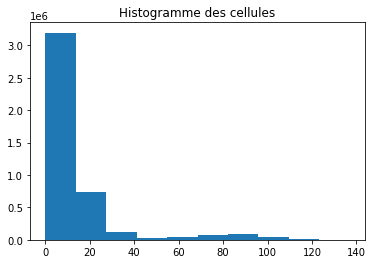

In [15]:
#Histogramme
image= mpimg.imread('hi.jpg') 
fig=image.ravel()
plt.figure()
plt.hist(fig)
plt.title('Histogramme des cellules')

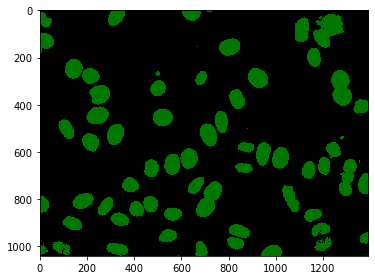

In [16]:
#Thresholding
ret,thresh = cv.threshold(image,60,120,cv.THRESH_BINARY)
io.imshow(thresh)

<Figure size 432x288 with 0 Axes>

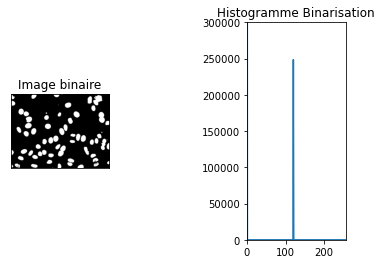

<Figure size 432x288 with 0 Axes>

In [17]:
#Binarisation
thresh1=thresh[...,1]

#Affichage
plt.subplot(1,3,1)
plt.imshow(thresh1,cmap='gray')
plt.title('Image binaire')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
hist,bin = np.histogram(thresh1.ravel(),256,[0,255])
plt.xlim([0,255])
plt.ylim([-0,300000])
plt.plot(hist)
plt.title('Histogramme Binarisation')
plt.figure()

(<matplotlib.image.AxesImage at 0x17729727be0>, Text(0.5, 1.0, 'open'))

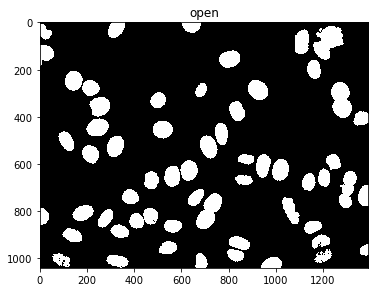

In [18]:
#Open image (Remplissage des trous)
open_image=thresh1
thresh1=threshold_otsu(open_image)
binary =open_image>thresh1
io.imshow(binary)
matrice= np.ones((20,20),np.uint8)
opening=morphology.remove_small_objects(binary,1004)

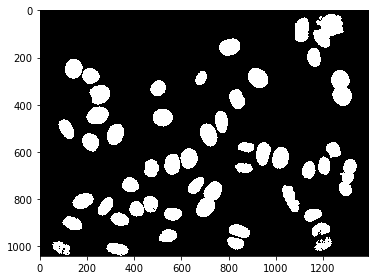

In [19]:
#Enlever les cellules aux bords
borderless=segmentation.clear_border(opening)

#Affichage
io.imshow(borderless)

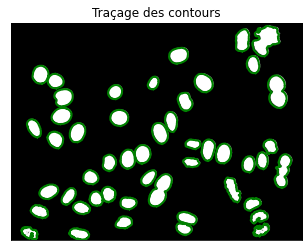

In [20]:
#Afin de detecter les cellules
contours=measure.find_contours(borderless,0.0001)
fig,ax =plt.subplots()
ax.imshow(borderless, cmap = plt.cm.gray)
for k in contours:
    if len(k)<200:
        continue
    ax.plot(k[:,1],k[:,0], linewidth=2, color="green")

#Affichage
plt.title("Traçage des contours")
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

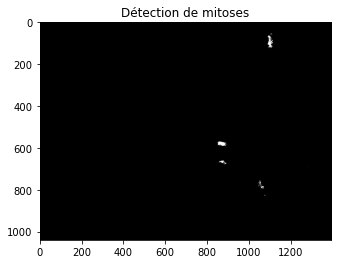

In [21]:
#Detection des mitoses (intensité)
image2=image[...,1]
mitose=image2>120

#Affichage
plt.figure()
plt.imshow(image)
plt.title("Détection de mitoses")
plt.imshow(mitose, cmap = "gray")

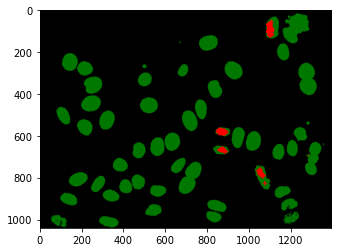

In [22]:
#1392x1040 (taille de l'image)
n_ligne=1392
n_colonne=1040
borderless1=segmentation.clear_border(thresh)

for i in range(n_colonne):
    for j in range(n_ligne):
        if (mitose[i,j]==True):
            for k in range(10):
                borderless1[i+k,j]=[255,0,0]
                borderless1[i-k,j]=[255,0,0]
                borderless1[i,j+k]=[255,0,0]
                borderless1[i,j-k]=[255,0,0]
#Affichage des zones auquels il pourrait avori une mitose
plt.imshow(borderless1)

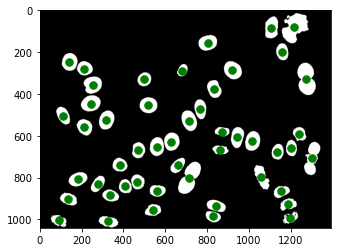

In [23]:
#Detection des centroides de toute les cellules
#Initialisation
image3 = np.zeros((1392, 1040))
a=[]
#Programme de centroides
rr, cc = ellipse(100, 100, 60, 50)
image3[rr, cc] = 1
label_img = label(borderless)
regions = regionprops(label_img)
fig, ax = plt.subplots()
ax.imshow(borderless, cmap=plt.cm.gray)
for props in regions:
    y0, x0 = props.centroid
    ax.plot(x0, y0, '.g', markersize=15)
    a.append(props.axis_major_length/ props.axis_minor_length)

#Affichage
ax.axis((0, 1392, 1040, 0))
plt.show()


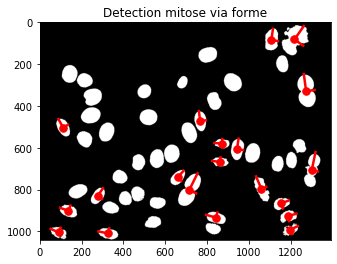

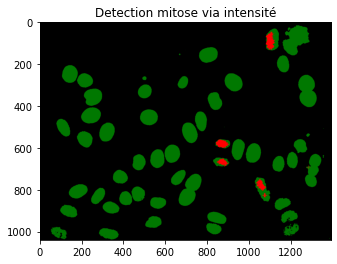

In [24]:
#Detection de mitoses (forme)
b=0.5*np.max(a)  #b correspond au rapport quasi maximal entre la longueur et la largeur d'une cellule
#Affichage
fig, ax = plt.subplots()
plt.title("Detection mitose via forme")
ax.imshow(borderless, cmap=plt.cm.gray)
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length
    if (props.axis_major_length/props.axis_minor_length>=b):
        ax.plot(x0, y0, '.r', markersize=15)
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        a.append(props.axis_major_length/ props.axis_minor_length)
    
ax.axis((0, 1392, 1040, 0))
plt.show()
plt.title("Detection mitose via intensité")
plt.imshow(borderless1)

### Si la cellule valide les deux conditions: intensité et forme. Alors la cellule correspond à une mitose

#### Après avoir tester le programme pour divers images, les améliorations peuvent correspondre prendre le  top 95% intensité -> mitose,top 98% forme -> mitose et top 90% des deux -> mitoses. En rendant le code plus strict, il y aura moins d'erreurs. De plus ceux qui pourraient être manqué pourraient être récupérée avec le critère casi parfait dans une des deux autres catégories. Il est aussi possible de mettre aussi un seuil de luminosité a 95% du pixel max, pour quand deux photos qui ne seront pas identique d'avoir un seuil dynamique qui reste viable.
#### Il est notamment possible de ne pas prendre le rapport entre la longeur et la largeur d'une cellule et de se rapprocher une formule d'ellipse afin d'évaluer la forme de celle-ci
#### Nous pouvons aussi faire le choix d'observer une photo auquel des élements géométriques seront placés uniquement sur nos mitoses afin de mieux les observer